共读取到 2 张图像，即将开始处理
4号图噪音占比为： 0.00457763671875 %
65号图噪音占比为： 0.05035400390625 %


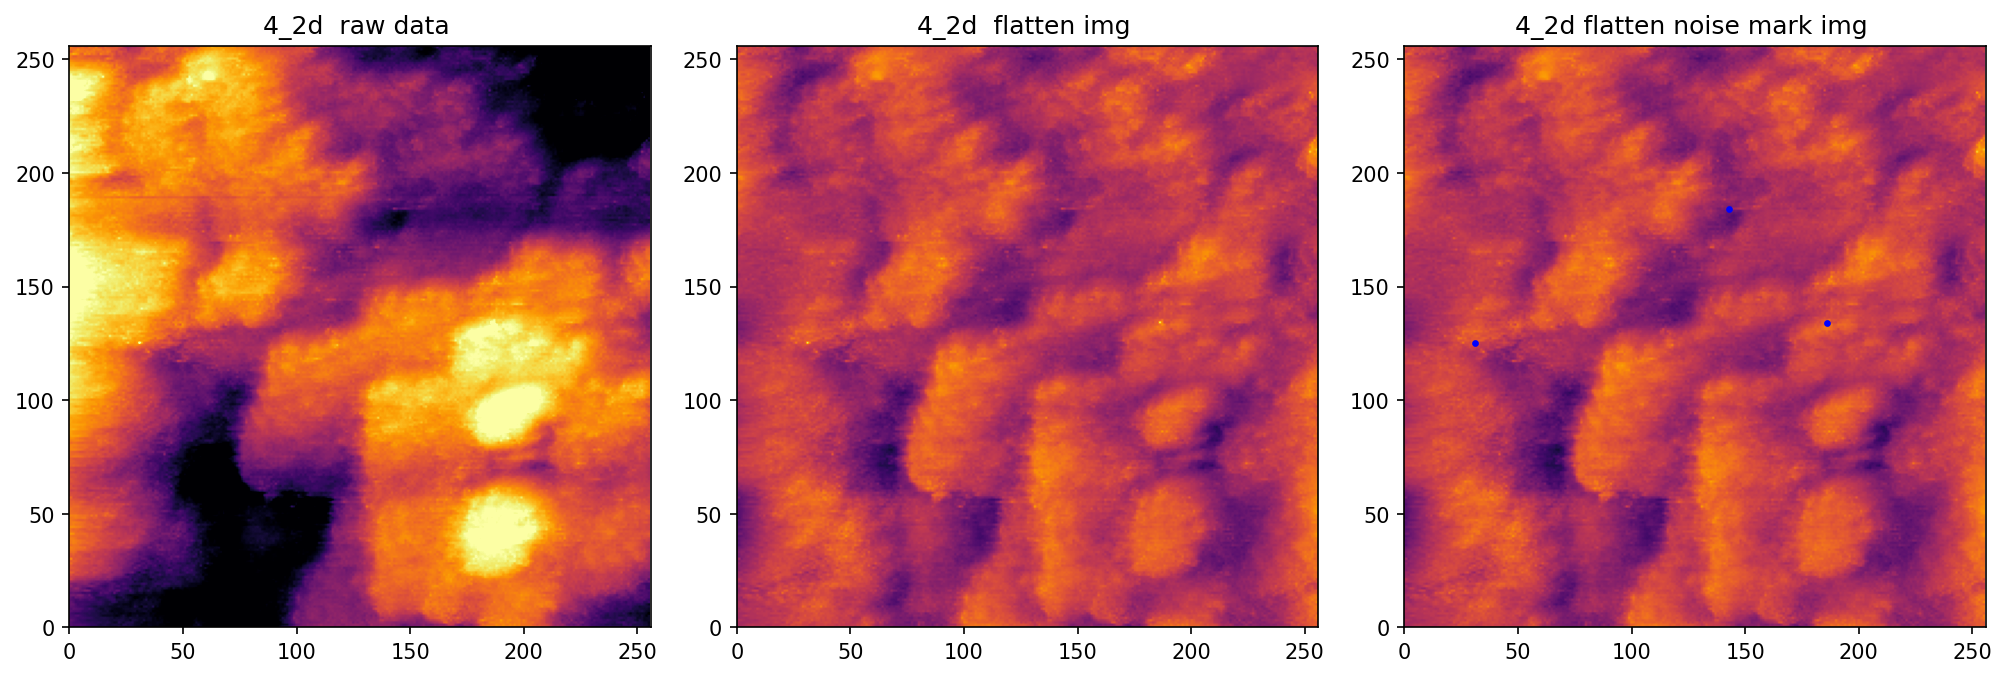

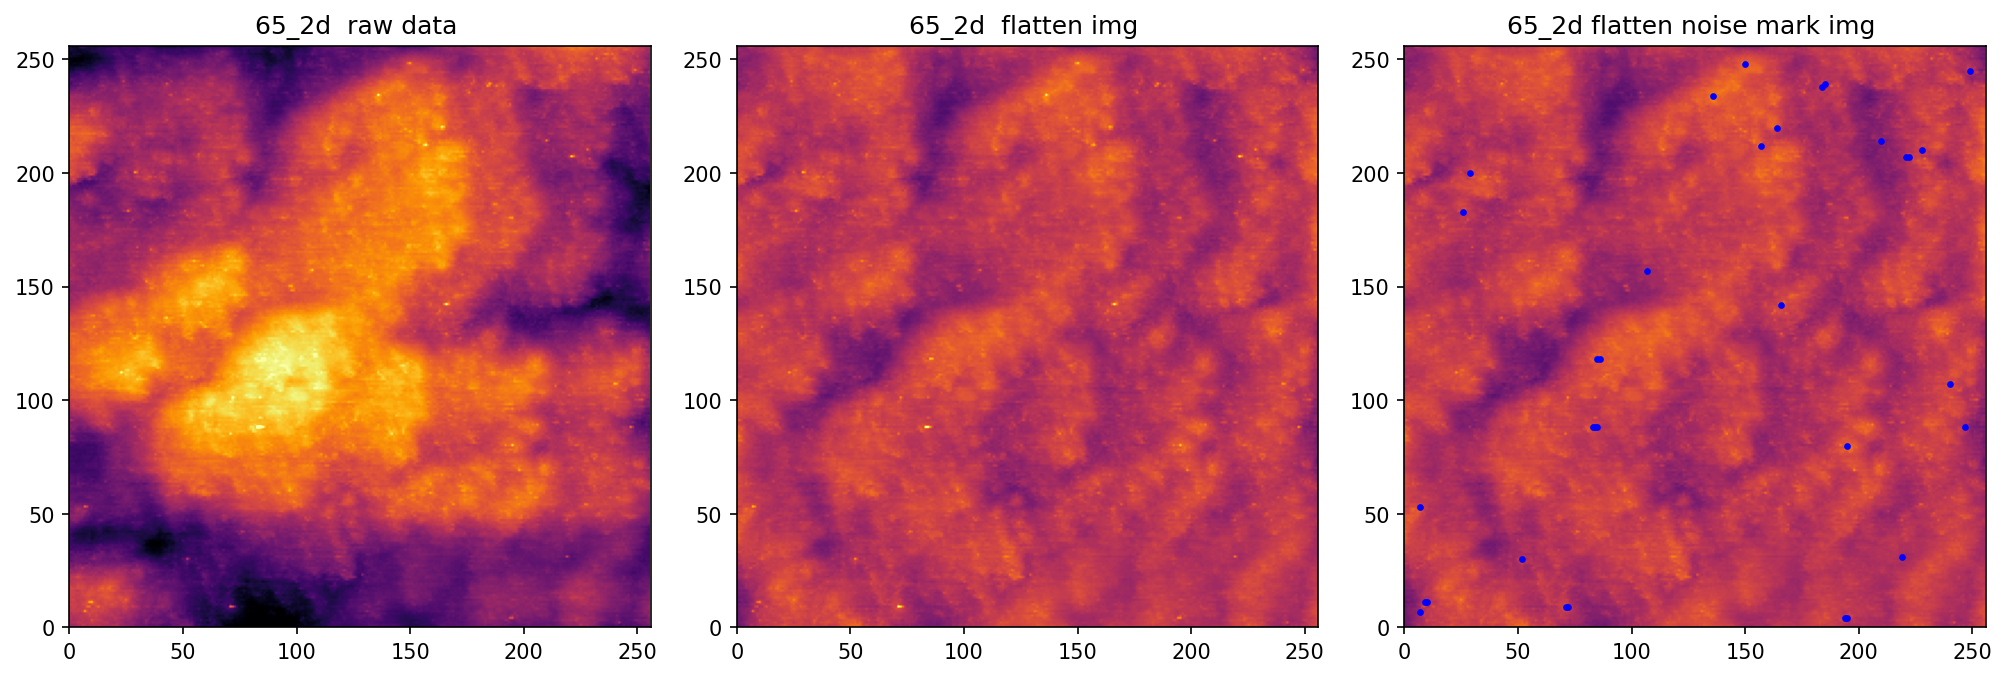

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import  glob
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

def show_3d_noise(file_name,img,noise_matrix):
    '''
    展示带高亮噪声点的3d模型
    输入：
    file_name：str类型，用于保存html文件的文件名
    img：np.array类型的二维矩阵，需要展示的图像
    noise_matrix：np.array类型的二维矩阵(2x噪声数量)，第一行是x值，第二行是y值。对应所有噪声点的坐标
    
    输出：无，函数会打印出3d模型并且保存在本地
    '''
    peak=[]
    peak_class=[]
    for i in range(noise_matrix.shape[1]):
        peak.append(img[noise_matrix[0][i]][noise_matrix[1][i]])
        peak_class.append('red')
    peak=np.array(peak)

    x_lines=[]
    y_lines=[]
    nomal_class=[]
    z_lines=[]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            x_lines.append(i)
            y_lines.append(j)
            nomal_class.append('blue')
            z_lines.append(img[i][j])
    x_lines=np.array(x_lines)
    y_lines=np.array(y_lines)
    
    x, y = np.linspace(0, 255, img.shape[0]), np.linspace(0, 255, img.shape[1])
    z_lines=np.array(z_lines)

    
    x_lines=np.concatenate((x_lines,noise_matrix[0]))
    y_lines=np.concatenate((y_lines,noise_matrix[1]))
    z_lines=np.concatenate((z_lines,peak))
    classes=np.concatenate((nomal_class,peak_class))

    
    
    fig = go.Figure(data=[go.Surface(z=img, x=x, y=y)])
    
    fig.add_trace(go.Scatter3d(
        x=noise_matrix[1],  # 设置3个不同的坐标数据
        y=noise_matrix[0], 
        z=peak,
        mode='markers',
        marker=dict(
        size=5,
        color='blue',
        opacity=0.8 ,showscale=True)
    ))
    
    fig.update_layout(
                scene = dict(
                    xaxis = dict(nticks=4, range=[0,255],),
                    yaxis = dict(nticks=4, range=[0,255],),
                    zaxis = dict(nticks=4, range=[-1.5,1.5],),),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
    
    fig.write_html(file_name+"_scatter_surface_3d.html")
    fig.show()
    
def show_3d(file_name,img):
    '''
    展示3d模型
    输入：
    file_name：str类型，用于保存html文件的文件名
    img：np.array类型的二维矩阵，需要展示的图像
    
    输出：无，函数会打印出3d模型并且保存在本地
    '''

    x_lines=[]
    y_lines=[]
    nomal_class=[]
    z_lines=[]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            x_lines.append(i)
            y_lines.append(j)
            nomal_class.append('blue')
            z_lines.append(img[i][j])
    x_lines=np.array(x_lines)
    y_lines=np.array(y_lines)
    
    x, y = np.linspace(0, 255, img.shape[0]), np.linspace(0, 255, img.shape[1])
    z_lines=np.array(z_lines)
    
    fig = go.Figure(data=[go.Surface(z=img, x=x, y=y)])
    
    fig.update_layout(
                scene = dict(
                    xaxis = dict(nticks=4, range=[0,255],),
                    yaxis = dict(nticks=4, range=[0,255],),
                    zaxis = dict(nticks=4, range=[-1.5,1.5],),),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
    
    fig.write_html(file_name+"_surface_3d.html")
    fig.show()

def flatten(img,degree):
    '''
    复现软件的Flatten操作
    https://www.nanophys.kth.se/nanolab/afm/icon/bruker-help/Content/SoftwareGuide/Offline/ModifyCommands/Flatten.htm
    输入：
    img：np.array类型的二维矩阵，需要flatten操作的图像
    degree：int类型正整数，要多项式拟合的最高次数
    
    输出：
    linear_img：np.array类型的二维矩阵，多项式拟合出来的图像
    flatten_img：np.array类型的二维矩阵，完成flatten操作的图像
    '''
    x_axis=[]
    y_pred=[]
    for x in range(256):
        x_axis.append(x)

    for i in range(256):#取每一行做多项式回归拟合
        y_train=img[i]#取第i行
        x_train=x_axis
        x_train=np.array(x_train).reshape(256,1)
        y_train=y_train.reshape(256,1)
        quadratic_featurizer = PolynomialFeatures(degree)
        X_train_quadratic = quadratic_featurizer.fit_transform(x_train)
        regressor_quadratic = LinearRegression()
        regressor_quadratic.fit(X_train_quadratic,y_train)
        Ypred = regressor_quadratic.predict(X_train_quadratic)  # 对测试结果进行预测
        y_pred.append(Ypred)

    linear_img=np.array(y_pred)
    linear_img=linear_img.reshape(256,256)
    flatten_img=img-linear_img#flatten图像就是原始图像减去拟合图像
    return linear_img,flatten_img


def show_highlight_noise(file_name,rawdata,flatten,noise_matrix):
    '''
    输出原始图像、flatten图像、噪声标记的flatten图像
    输入：
    file_name：str类型，用于保存图像的文件名
    rawdata：np.array类型的二维矩阵，原始图像
    flatten：np.array类型的二维矩阵，flatten操作后的图像
    noise_matrix：np.array类型的二维矩阵(2x噪声数量)，第一行是x值，第二行是y值。对应所有噪声点的坐标
    
    输出：无，函数会打印出图像并且保存在本地
    
    '''
    row = 1
    col = 3
    vmin=-1
    vmax=1
    # cmap = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
    fig = plt.figure(figsize=(4.5*col,4.5*row), dpi=150, facecolor='white')
    gs = fig.add_gridspec(row,col)
    

    ax  = fig.add_subplot(gs[0])
    ax.imshow(rawdata, vmin=vmin, vmax=vmax, cmap='inferno')
    ax.set_ylim(0,256)
    ax.set_xlim(0, 256)
    ax.set_title(file_name+" raw data ")
    
    
    
    ax  = fig.add_subplot(gs[1])
    ax.imshow(flatten, vmin=vmin, vmax=vmax, cmap='inferno')
    ax.set_ylim(0, 256)
    ax.set_xlim(0, 256)
    ax.set_title(file_name+" flatten img ")
    
    ax  = fig.add_subplot(gs[2])
    plt.scatter(x=noise_matrix[1], y=noise_matrix[0],s=5,c='b')
    ax.imshow(flatten, vmin=vmin, vmax=vmax, cmap='inferno')
    ax.set_ylim(0, 256)
    ax.set_xlim(0, 256)
    ax.set_title(file_name+"flatten noise mark img ")
    

    fig.tight_layout()
    fig.show()
    fig.savefig(file_name)

    

def compute_local_edge_mean(local_patch,radius):
    '''
    计算当前判断点区域的边缘平均值（用于计算阈值并判断是否为噪音）
    输入：
    local_patch：np.array类型的二维矩阵，当前判断点指定半径内的图片局部区域
    radius：int 正整数，半径长度
    
    输出：局部区域边缘均值
    '''
    #边界上的值平均
    local_mean=[]
    max_num=(np.array(local_patch).shape)[0]
    local_mean.append(local_patch[0,:])
    local_mean.append(local_patch[max_num-1,:])
    local_mean.append(local_patch[:,0])
    local_mean.append(local_patch[:,max_num-1])
    sum_num=(np.array(local_mean).sum())-local_patch[0,0]-local_patch[0,max_num-1]-local_patch[max_num-1,0]-local_patch[max_num-1,max_num-1]
    local_edge_mean=sum_num/(4*(max_num-1))
    
    return local_edge_mean
    
def is_noise(local_patch,threshold,radius,topk):
    '''
    判断当前点是否属于噪音点
    输入：
    local_patch：np.array类型的二维矩阵，当前判断点指定半径内的图片局部区域
    threshold：float，当前点和局部区域边缘均值的阈值
    radius：int 正整数，半径长度
    topk：int 正整数，当前点是当前局部区域所有点的前topk个值
    
    输出：
    peak_point：int 范围为0~topk
                如果是局部topk极大值，但是与边缘均值的差小于阈值，返回0，判断为不是噪音。
                如果不是局部topk极大值，返回0，判断为不是噪音。
                其他情况均返回大于0的正整数，判断为是噪音。
    '''
    #假设就是极大值
    peak_point=topk
    for i in range(2*radius-1):
        for j in range(2*radius-1):
            if local_patch[i][j]>=local_patch[radius-1][radius-1]:
                if i!=(radius-1) or j!=(radius-1):#不是它本身
                    peak_point-=1#范围内有值比它大或者等于它，该点不是极大值
                    if peak_point==0:
                        return peak_point

    
    local_min=compute_local_edge_mean(local_patch,radius)
    if local_patch[radius-1][radius-1]-local_min<threshold:
        peak_point=0#虽然是极大值，但是在阈值以内
        return peak_point
    else:
        return peak_point#周围的值都不如它大，

def get_noise_matrix(file_name,threshold,radius,topk,img):
    '''
    得到噪声矩阵，噪声矩阵为2x噪声数量，保存噪声的坐标
    输入：
    file_name：str类型，用于保存图像的文件名
    threshold：float，当前点和局部区域边缘均值的阈值
    radius：int 正整数，半径长度
    topk：int 正整数，当前点是当前局部区域所有点的前topk个值
    img：np.array类型的二维矩阵，需要寻找噪声区域的图像
    
    输出：
    noise_matrix：np.array类型的二维矩阵(2x噪声数量)，第一行是x值，第二行是y值。对应所有噪声点的坐标
    打印噪声点所占比例
    '''
    x=[]
    y=[]
    img=np.array(img)
    length=(img.shape)[0]
    minimum=np.min(img)
    img_pad = np.pad(img,radius,'linear_ramp')
    for i in range(radius,length+radius):
        for j in range(radius,length+radius):
            local_patch=img_pad[i-radius+1:i+radius,j-radius+1:j+radius]
            if is_noise(local_patch,threshold,radius,topk):
                    x.append(i-radius)
                    y.append(j-radius)

    noise_matrix=list(zip(x,y))
    noise_num=(np.array(noise_matrix).shape)[0]
    print(file_name+"号图噪音占比为：",(100*(noise_num)/(256**2)),"%")
    noise_matrix=np.swapaxes(noise_matrix, 0, 1)
    return noise_matrix

def Flatten_Mark_noise(data_path,
                       degree,
                       threshold,
                       radius,
                       topk,
                       show_data_2d,
                       show_data_3d):
    '''
    对指定路径的所有图像完成Flatten操作并标记噪声后输出2d、3d图像
    输入：
    data_path：批量图片存储的路径，默认为当前目录下的img文件夹
    degree：int类型正整数，要多项式拟合的最高次数
    threshold：float，当前点和局部区域边缘均值的阈值
    radius：int 正整数，半径长度
    topk：int 正整数，当前点是当前局部区域所有点的前topk个值
    show_data_2d：bool，是否输出2d示意图
    show_data_3d：bool，是否输出3d示意图
    
    输出：打印噪声点所占比例，函数会打印出图像并且保存在本地
    '''
    data_path+=(r'*.txt')
    data_path = glob.glob(data_path)
    img_names=[]
    imgs=[]
    for i in range(len(data_path)):
        img_name=data_path[i]
        img_name= img_name[img_name.rfind('0')+1:img_name.rfind('.s')]
        img_names.append(img_name)
        
        img=np.loadtxt(data_path[i])
        img = img.reshape(256, 256)
        imgs.append(img)
    img_names=np.array(img_names)
    imgs=np.array(imgs)

    print("共读取到",len(img_names),"张图像，即将开始处理")
    for i in range(len(img_names)):
        linear_img,flatten_img=flatten(imgs[i],degree)
        noise_matrix=get_noise_matrix(img_names[i],threshold,radius,topk,flatten_img)
        if show_data_2d:
            show_highlight_noise(img_names[i]+'_2d ',imgs[i],flatten_img,noise_matrix)
        if show_data_3d:
            show_3d(img_names[i]+'_3d',imgs[i])
            show_3d(img_names[i]+'_flatten_3d',flatten_img)
            show_3d_noise(img_names[i]+"_flatten_noise_3d",flatten_img,noise_matrix)
        

def main():
    degree=3 #多项式拟合最高次           默认使用3次多项式拟合
    threshold=0.4 #判断噪音点与周围一圈像素点平均值差值的阈值
    radius=3#判断噪音点的半径，算上中心点，如radius=2 就是只算了3x3像素的矩阵
    topk=3#噪音点不一定是本区域最大值，这里topk就是指噪音点可以是本区域的前k大的值
    show_data_2d=True #输出2d图像 包括原始图像 flatten图像 带噪声标记的flatten图像
    show_data_3d=False #输出3d图像 包括原始图像 flatten图像 带噪声标记的flatten图像 方便看flatten和噪声效果的
    data_path=r'img/'#ttxt文件放到当前目录下的img文件夹即可
    Flatten_Mark_noise(data_path,
                       degree,
                       threshold,
                       radius,
                       topk,
                       show_data_2d,
                       show_data_3d
                      )
    

if __name__ == '__main__':
    main()    